In [2]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../../analysisTools/")
from skimmerTools import Skimmer
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py

### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [3]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [4]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [5]:
suffix = "_TrueVertexForSignal"

In [6]:
cut_config = "./cut_configs/preselections_BDTv2.py"

In [7]:
sig_sample_json_dir = '../'
jsons = [f for f in os.listdir(sig_sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if "skimmed_sig_v2_mA_3m1_2018_aEM_ctau-10." in samp ]
print(signal_list)

bkg_sample_json_dir = '../../../configs/sample_configs/'
jsons = [f for f in os.listdir(bkg_sample_json_dir) if ".json" in f]

bkg_list = [ samp.split('.')[0] for samp in jsons if "skimmed_bkg" in samp ]
print(bkg_list)

['skimmed_sig_v2_mA_3m1_2018_aEM_ctau-10']
['skimmed_bkg_2018_DY', 'skimmed_bkg_2018_Diboson', 'skimmed_bkg_2018_QCD_TuneCP5_PSWeights', 'skimmed_bkg_2018_TTJetsDiLept', 'skimmed_bkg_2018_Top', 'skimmed_bkg_2018_Triboson', 'skimmed_bkg_2018_WJets', 'skimmed_bkg_2018_ZJets']


In [8]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sig_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_sig_v2_mA_3m1_2018_aEM_ctau-10


Output()

Output()

Completed in 0.80 min



In [9]:
for samp in bkg_list:
    if 'TTJetsDiLept' in samp: # currently not available ntuples
        continue
    
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{bkg_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_bkg_2018_DY


Output()

Output()

Completed in 0.85 min

Start analyzing: skimmed_bkg_2018_Diboson


Output()

Output()

Completed in 0.53 min

Start analyzing: skimmed_bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Completed in 3.32 min

Start analyzing: skimmed_bkg_2018_Top


Output()

Output()

Completed in 5.08 min

Start analyzing: skimmed_bkg_2018_Triboson


Output()

Output()

Completed in 0.32 min

Start analyzing: skimmed_bkg_2018_WJets


Output()

Output()

Completed in 2.43 min

Start analyzing: skimmed_bkg_2018_ZJets


Output()

Output()

Completed in 2.46 min



## BDT

In [10]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [11]:
h5_dir = "./h5/"
sig_suffix = "ctau-10_TrueVertexForSignal"
bkg_suffix = "_TrueVertexForSignal"

ctau = '10_'
sig_files = [f for f in os.listdir(h5_dir) if (sig_suffix in f and 'sig' in f) and (str(ctau) in f)]
bkg_files = [f for f in os.listdir(h5_dir) if bkg_suffix in f and 'bkg' in f]

# vtx variables
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy_signif']

sig_data = []

sig_xsec_norm = []
sig_point = {'m1':[], 'delta':[], 'ctau':[]}

for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])
        
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        
        sig_data.append(np.concatenate([fin[v][()][mask].reshape(-1,1) for v in variables],axis=1))
        sig_xsec_norm.append(fin['wgt_norm'][()][mask])
        
        sig_point['m1'].append(fin['m1'][()][mask])
        sig_point['delta'].append(fin['delta'][()][mask])
        sig_point['ctau'].append(fin['ctau'][()][mask])

sig_data = np.concatenate(sig_data,axis=0)
sig_xsec_norm = np.concatenate(sig_xsec_norm,axis=0)
sig_point['m1'] = np.concatenate(sig_point['m1'], axis=0)
sig_point['delta'] = np.concatenate(sig_point['delta'], axis=0)
sig_point['ctau'] = np.concatenate(sig_point['ctau'], axis=0)

nBkg = 0
bkg_data = []

bkg_xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])
        
        bkg_data.append(np.concatenate([fin[v][()].reshape(-1,1) for v in variables],axis=1))
        bkg_xsec_norm.append(fin['wgt_norm'][()])

bkg_xsec_norm = np.concatenate(bkg_xsec_norm,axis=0)


print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

Signal events 4352 -> 4352 after gen matching (raw counts)

DY: 9
Diboson: 767
QCD: 3
Top: 2006
Triboson: 92
WJets: 29090
ZJets: 44480

Number of total background events (raw counts): 76447


In [12]:
print('Signal input statistics (unweighted)')

sig_subprocess = {}

ctau = 10.
for delta in [0.1, 0.2]:
    for m1 in [5.,10.,20.,30.,40.,50.]:
        idx = ((sig_point['m1'] == m1) & (sig_point['delta'] == delta))&(sig_point['ctau'] == ctau)
        point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
        sig_subprocess[point] = idx
        print(f'{point}: {np.sum(idx)}')

nSamp = 0
for samp, count in sig_subprocess.items():
    if np.sum(count) != 0:
        nSamp += 1
    else:
        print(f'{samp} has zero counts')

print(f'Number of signal subprocesses with non-zero count: {nSamp}')

Signal input statistics (unweighted)
m1_5.0_delta_0.1_ctau_10.0: 112
m1_10.0_delta_0.1_ctau_10.0: 257
m1_20.0_delta_0.1_ctau_10.0: 239
m1_30.0_delta_0.1_ctau_10.0: 509
m1_40.0_delta_0.1_ctau_10.0: 528
m1_50.0_delta_0.1_ctau_10.0: 705
m1_5.0_delta_0.2_ctau_10.0: 84
m1_10.0_delta_0.2_ctau_10.0: 227
m1_20.0_delta_0.2_ctau_10.0: 386
m1_30.0_delta_0.2_ctau_10.0: 441
m1_40.0_delta_0.2_ctau_10.0: 585
m1_50.0_delta_0.2_ctau_10.0: 279
Number of signal subprocesses with non-zero count: 12


## Reweight Backgrounds

### Background raw counts

In [13]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])

        bkg_raw[process] = entries

DY: 9
Diboson: 767
QCD: 3
Top: 2006
Triboson: 92
WJets: 29090
ZJets: 44480


### Cutflow counts (xsec weighted)

In [14]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = sum(fin['wgt_norm'][()])
        print(f'{process}: {entries}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts}')

DY: 455.6547508239746
Diboson: 189.35027223825455
QCD: 632.250424861908
Top: 294.0013522002846
Triboson: 2.0868917726911604
WJets: 11204.390249389457
ZJets: 6256.761405692319
Total background counts (xsec weighted): 19034.49534697889


### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`

Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct.

In [15]:
sf = {}
xsec_norm = {}

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = fin['wgt_norm'][()] / total_bkg_cts * nBkg
        #print(f'{process}: {entries}')

        sf[process] = entries
        xsec_norm[process] = fin['wgt_norm'][()]

**With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now.**

In [16]:
total_weighted = 0

for process in sf.keys():
    print(f'{process}: {sum(sf[process])}')
    total_weighted += sum(sf[process])

print(total_weighted)

DY: 1830.0163174034096
Diboson: 760.4751062962587
QCD: 2539.266046933393
Top: 1180.7783581768153
Triboson: 8.381446863224525
WJets: 44999.45869872773
ZJets: 25128.620790256326
76446.99676465715


In [17]:
nBkg

76447

In [18]:
# SF
bkg_sf = []
bkg_xsec_norm = []

for process in sf.keys():
    bkg_sf += list(sf[process])
    bkg_xsec_norm += list(xsec_norm[process])

#print(len(bkg_sf))

In [19]:
set(bkg_xsec_norm)

{-0.05953975,
 -0.045444746,
 -0.016287146,
 -0.012563892,
 -0.0042385785,
 0.00075470324,
 0.0012511426,
 0.0042385785,
 0.004238579,
 0.01063748,
 0.012563892,
 0.016287146,
 0.024323996,
 0.028713468,
 0.030013198,
 0.037092578,
 0.038779505,
 0.039841752,
 0.043379143,
 0.045444746,
 0.05953975,
 0.08565486,
 0.18472649,
 0.19808361,
 0.2163429,
 0.2441929,
 0.2524531,
 0.29107392,
 0.34455764,
 0.3913622,
 0.55844516,
 1.1887455,
 2.7895231,
 7.842954,
 24.090977,
 143.50896,
 312.20374}

In [20]:
len(bkg_sf)

76447

## Reweight Signal

For signal, we also apply the reweighting factors.
1) First, since our signal samples are smaller than background samples, get the overall scale factor for signal samples to match the total number of background samples. Reweigh against background.
2) Then, reweigh across signal samples. We will make all signal subprocesses "equally shown" to the BDT. Currently the inputs are biased, i.e. to have more 10% splitting, 1mm ctau, etc. We will flatten these out.

In [21]:
bkg_to_sig = len(bkg_xsec_norm)/len(sig_xsec_norm)

print(f'Signal sample size (all subprocesses summed): {len(sig_xsec_norm)}')
print(f'Background sample size (all subprocesses summed): {len(bkg_xsec_norm)}')
print(f'{bkg_to_sig} more background than signal samples')

Signal sample size (all subprocesses summed): 4352
Background sample size (all subprocesses summed): 76447
17.56594669117647 more background than signal samples


In [22]:
print(f'There are {nSamp} subprocesses in signal, i.e. per m1/delta/ctau points.')
print(f'\nIdeally, sig and bkg sample size for BDT input should be the same.')
print(f'\nFor background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.')
print(f'This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.')
print(f'\nFor signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.')
print(f'But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.')
print(f'For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.')

There are 12 subprocesses in signal, i.e. per m1/delta/ctau points.

Ideally, sig and bkg sample size for BDT input should be the same.

For background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.
This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.

For signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.
But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.
For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.


In [23]:
print(f'This means, for each one of {nSamp} signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = {len(bkg_xsec_norm)/nSamp}')

This means, for each one of 12 signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = 6370.583333333333


In [24]:
print(f'We will get the SF for each signal subprocess such that their weighted count corresponds to {len(bkg_xsec_norm)/nSamp}')

We will get the SF for each signal subprocess such that their weighted count corresponds to 6370.583333333333


In [25]:
sig_sf = np.zeros(len(sig_xsec_norm)) # initialize

nSubprocessWeighted = len(bkg_xsec_norm)/nSamp
#nSubprocessWeighted = nSamp

for samp, idx in sig_subprocess.items():
    samp_idx = np.nonzero(idx)[0]
    nSubprocess = np.sum(idx) # unweighted
    if nSubprocess == 0:
        continue
    sf = nSubprocessWeighted/nSubprocess

    sig_sf[samp_idx] = sf

print(sig_sf)

[22.83363202 22.83363202 22.83363202 ... 24.788262   24.788262
 24.788262  ]


In [26]:
type(sig_sf)

numpy.ndarray

### Train

In [27]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = sig_sf

In [28]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=0.8, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=0.8, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=0.8, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=0.8, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=0.8, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [29]:
test_ctau[np.where(y_test == 1)] # signal

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10

In [30]:
test_ctau[np.where(y_test == 0)] # bkg; should all be zeros by construction, printing out to check if this is the case (not messed up by random_state)

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)
#bst.fit(train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [32]:
# make predictions
preds = bst.predict(test)

In [33]:
os.system('mkdir -p plots')

0

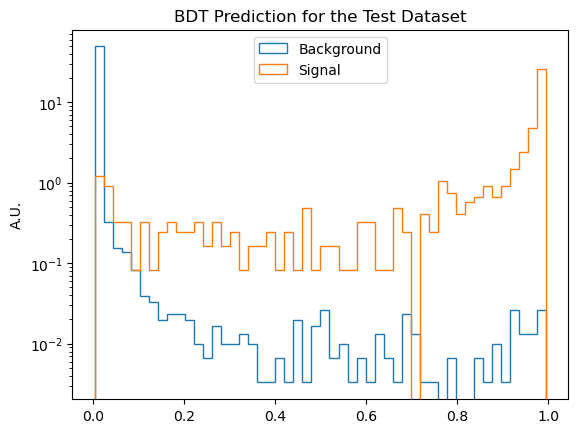

In [34]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
plt.savefig('plots/BDTv2_ctau-10_score.png')
plt.yscale('log')

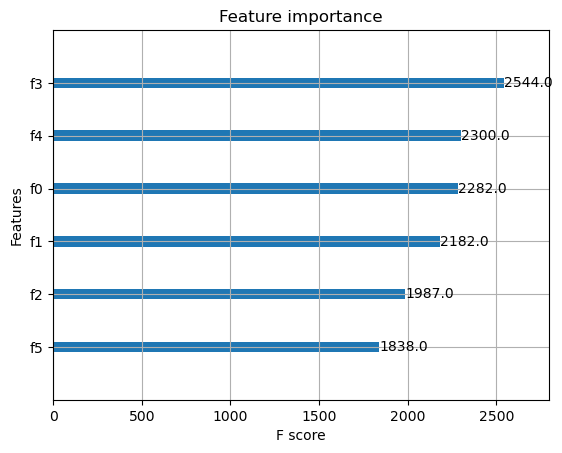

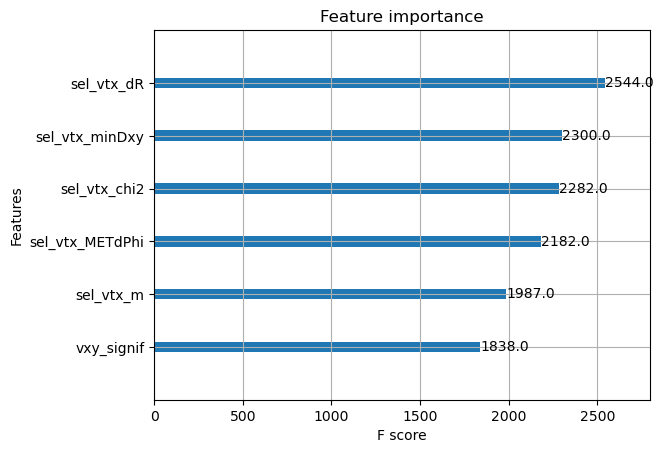

In [35]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
plt.savefig('plots/BDTv2_ctau-10_importance_bst.png', bbox_inches = "tight")

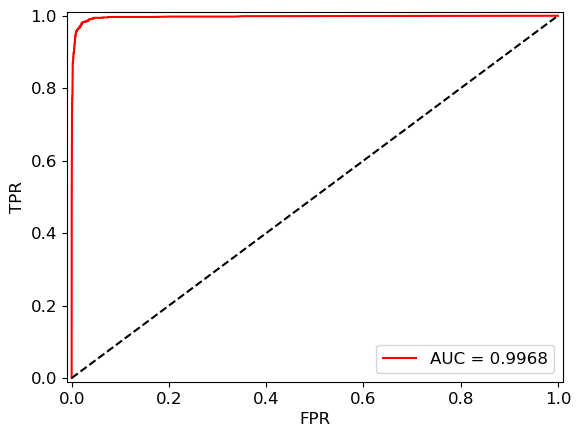

In [36]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
plt.savefig('plots/BDTv2_ctau-10_roc_curve.png')

### Save and load

In [37]:
bst.save_model('models/BDTv2_ctau-10_5to50.json')

In [38]:
trained_model = xgb.XGBRegressor()
trained_model.load_model("models/BDTv2_ctau-10_5to50.json")

In [39]:
prediction = trained_model.predict(test)

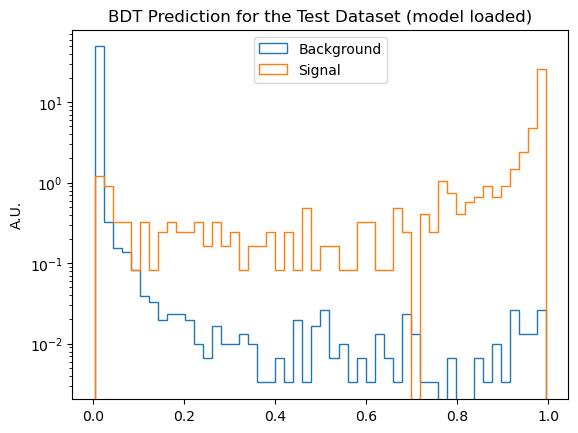

In [40]:
bins = 50

h,bins,_ = plt.hist(prediction[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(prediction[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset (model loaded)')

plt.ylabel('A.U.')
plt.yscale('log')

[Text(0, 0, 'vxy_signif'),
 Text(0, 1, 'sel_vtx_m'),
 Text(0, 2, 'sel_vtx_METdPhi'),
 Text(0, 3, 'sel_vtx_chi2'),
 Text(0, 4, 'sel_vtx_minDxy'),
 Text(0, 5, 'sel_vtx_dR')]

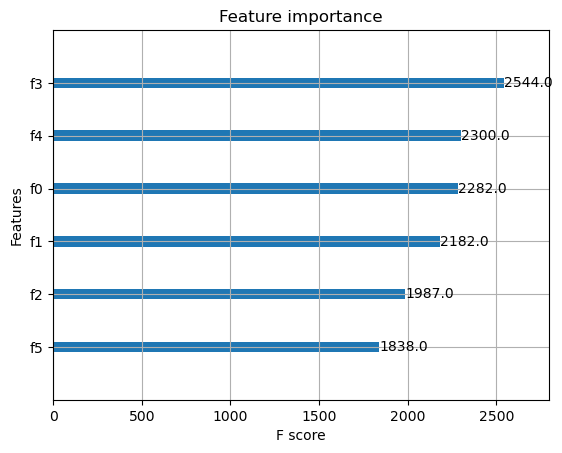

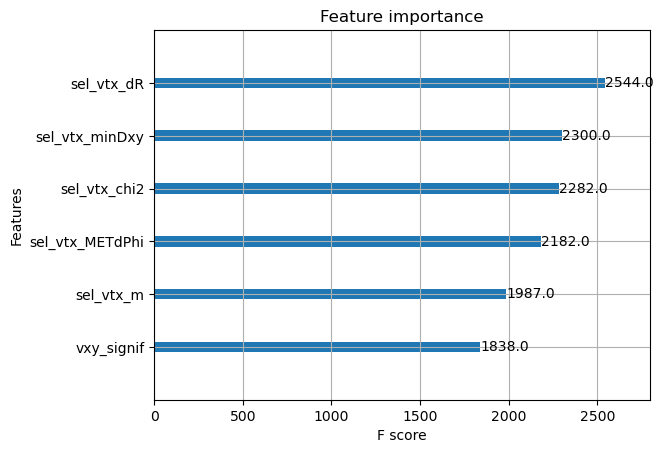

In [41]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(trained_model)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(trained_model).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

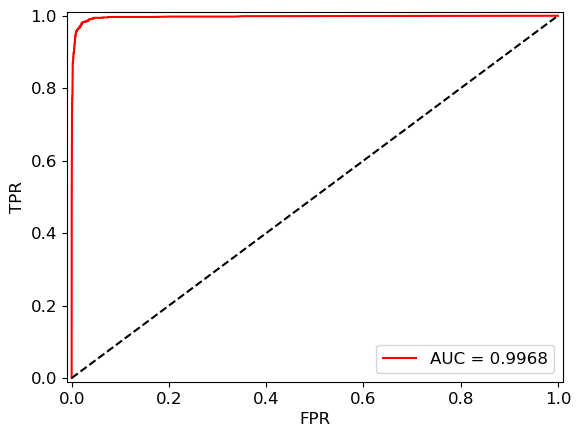

In [42]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
precision, recall, thresholds2 = precision_recall_curve(y_test, prediction)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### WP

In [43]:
idx_valid = thresholds < 1

tpr = tpr[idx_valid]
thresholds = thresholds[idx_valid]

In [44]:
tpr_WP = {'tight': 0.7, 'medium': 0.8, 'loose': 0.9}
thres_WP = {'tight': 0, 'medium': 0, 'loose': 0}

In [45]:
epsilon = 0.04

for wp in tpr_WP.keys():    
    idx = np.where((tpr > tpr_WP[wp] - epsilon) & (tpr < tpr_WP[wp] + epsilon))
    
    thres_WP[wp] = thresholds[idx].mean()

    print(f'{wp} threshold: {thres_WP[wp]}')

tight threshold: 0.9581883549690247
medium threshold: 0.8967224359512329
loose threshold: 0.45587649941444397


### TPR

In [46]:
# BDT scores for the signal
nPass_sig = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    nPass_sig[wp] = np.sum(preds[np.where(y_test==1)] > thres_WP[wp])
    nPass_bkg[wp] = np.sum(preds[np.where(y_test==0)] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig[wp]} / {len(preds[np.where(y_test==1)])} = {nPass_sig[wp]/len(preds[np.where(y_test==1)])}')
    print(f'FPR: {nPass_bkg[wp]} / {len(preds[np.where(y_test==0)])} = {nPass_bkg[wp]/len(preds[np.where(y_test==0)])}')


tight pass
TPR: 620 / 871 = 0.711825487944891
FPR: 11 / 15290 = 0.0007194244604316547

medium pass
TPR: 689 / 871 = 0.7910447761194029
FPR: 25 / 15290 = 0.0016350555918901242

loose pass
TPR: 790 / 871 = 0.9070034443168772
FPR: 77 / 15290 = 0.005035971223021582


In [47]:
# for a given point
m1 = 30.
delta = 0.1
ctau = 10.

nPass_sig_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
    bkg_idx = np.where(y_test==0)
    
    nPass_sig_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
    nPass_bkg_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig_sigpoint[wp]} / {len(preds[sig_idx])} = {nPass_sig_sigpoint[wp]/len(preds[sig_idx])}')
    print(f'FPR: {nPass_bkg_sigpoint[wp]} / {len(preds[bkg_idx])} = {nPass_bkg_sigpoint[wp]/len(preds[bkg_idx])}')


tight pass
TPR: 71 / 94 = 0.7553191489361702
FPR: 11 / 15290 = 0.0007194244604316547

medium pass
TPR: 79 / 94 = 0.8404255319148937
FPR: 25 / 15290 = 0.0016350555918901242

loose pass
TPR: 86 / 94 = 0.9148936170212766
FPR: 77 / 15290 = 0.005035971223021582


### TPR per signal point

In [48]:
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [10.]:
    for delta in [0.1, 0.2]:
        for m1 in [5., 10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])

                if len(sig_idx[0]) == 0:
                    tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(0)
                    continue
                
                print(f'm1 = {m1}, delta = {delta}, ct = {ctau}')
                print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')

                tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(nPass_sig_raw_sigpoint[wp]/len(sig_idx[0]))

m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 10 / 27 = 0.37037037037037035
m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 13 / 27 = 0.48148148148148145
m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 23 / 27 = 0.8518518518518519
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 29 / 50 = 0.58
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 35 / 50 = 0.7
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 45 / 50 = 0.9
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 34 / 51 = 0.6666666666666666
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 41 / 51 = 0.803921568627451
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 47 / 51 = 0.9215686274509803
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 71 / 94 = 0.7553191489361702
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 79 / 94 = 0.8404255319148937
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 86 / 94 = 0.9148936170212766
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 78 / 101 = 0.7722772277227723
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 81 / 101 = 0.801980198019802
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 94 / 101 = 0.9306930693069307
m1 = 50.0, delta = 0.1, 

In [49]:
tpr_raw

{'0.1': {'ct-1': {'tight': [], 'medium': [], 'loose': []},
  'ct-10': {'tight': [0.37037037037037035,
    0.58,
    0.6666666666666666,
    0.7553191489361702,
    0.7722772277227723,
    0.6751592356687898],
   'medium': [0.48148148148148145,
    0.7,
    0.803921568627451,
    0.8404255319148937,
    0.801980198019802,
    0.7452229299363057],
   'loose': [0.8518518518518519,
    0.9,
    0.9215686274509803,
    0.9148936170212766,
    0.9306930693069307,
    0.8407643312101911]},
  'ct-100': {'tight': [], 'medium': [], 'loose': []}},
 '0.2': {'ct-1': {'tight': [], 'medium': [], 'loose': []},
  'ct-10': {'tight': [0.4666666666666667,
    0.6744186046511628,
    0.7529411764705882,
    0.8461538461538461,
    0.7075471698113207,
    0.7843137254901961],
   'medium': [0.6,
    0.813953488372093,
    0.8588235294117647,
    0.8681318681318682,
    0.7924528301886793,
    0.8431372549019608],
   'loose': [0.8,
    0.9534883720930233,
    0.9529411764705882,
    0.9560439560439561,
    0.

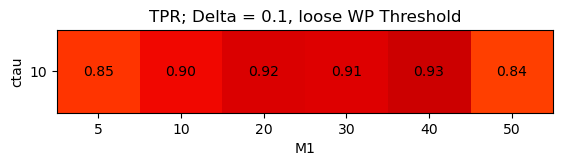

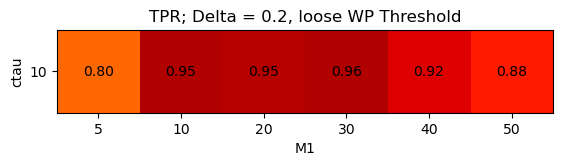

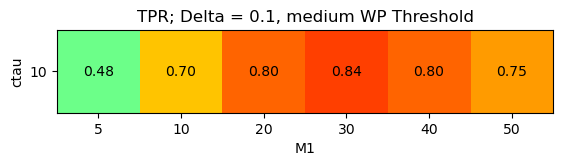

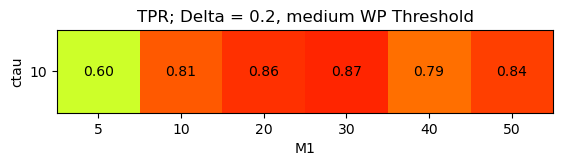

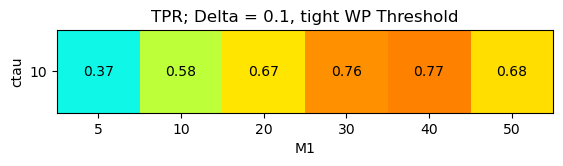

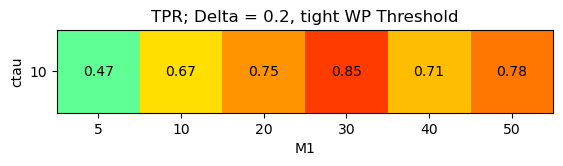

In [50]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-10'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [10])
        plt.gca().invert_yaxis()
        
        plt.show()

### TPR on half dataset (not just 20%)

In [78]:
train_size = 0.5

sig_train, sig_test = train_test_split(sig_data,train_size=train_size,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=train_size, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=train_size, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=train_size, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=train_size, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=train_size, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=train_size,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=train_size, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=train_size, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

#perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

#perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [79]:
preds = bst.predict(test)

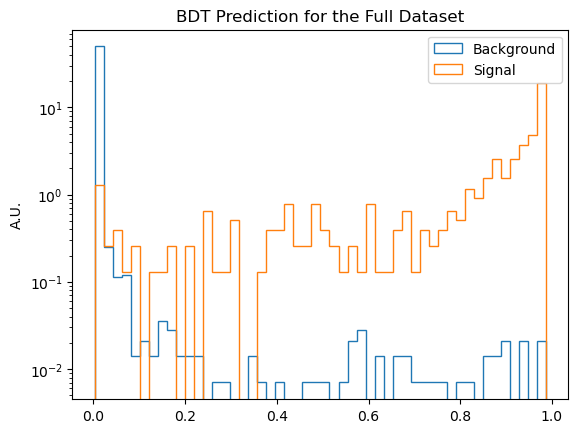

In [80]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Full Dataset')

plt.ylabel('A.U.')
#plt.savefig('plots/BDTscore.png')
plt.yscale('log')

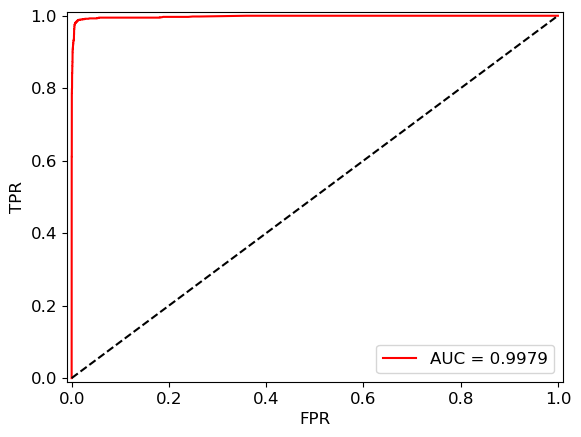

In [81]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

In [83]:
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [10.]:
    for delta in [0.1, 0.2]:
        for m1 in [5., 10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])

                if len(sig_idx[0]) == 0:
                    tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(0)
                    continue
                
                print(f'm1 = {m1}, delta = {delta}, ct = {ctau}')
                print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')

                tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(nPass_sig_raw_sigpoint[wp]/len(sig_idx[0]))

m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 8 / 23 = 0.34782608695652173
m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 10 / 23 = 0.43478260869565216
m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 19 / 23 = 0.8260869565217391
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 48 / 62 = 0.7741935483870968
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 54 / 62 = 0.8709677419354839
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 59 / 62 = 0.9516129032258065
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 47 / 59 = 0.7966101694915254
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 50 / 59 = 0.847457627118644
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 55 / 59 = 0.9322033898305084
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 89 / 119 = 0.7478991596638656
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 98 / 119 = 0.8235294117647058
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 110 / 119 = 0.9243697478991597
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 115 / 156 = 0.7371794871794872
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 126 / 156 = 0.8076923076923077
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 138 

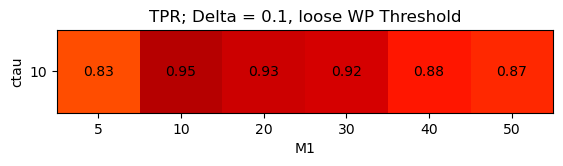

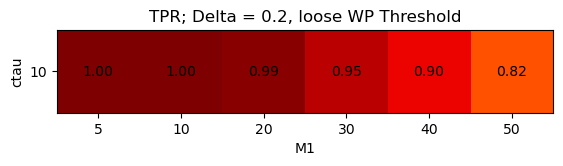

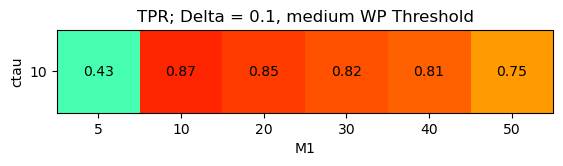

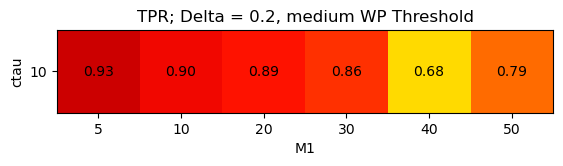

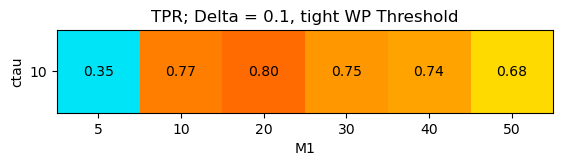

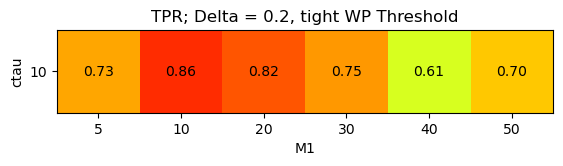

In [84]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-10'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [10])
        plt.gca().invert_yaxis()
        
        plt.show()

### Pearson Correlation Coefficient

In [54]:
import pandas as pd

df_bkg = pd.DataFrame(bkg_data, columns = variables)
df_sig = pd.DataFrame(sig_data, columns = variables)
df_all = pd.DataFrame(np.concatenate((bkg_data,sig_data),axis=0), columns = variables)

In [55]:
corr_all = df_all.corr()
corr_bkg = df_bkg.corr()
corr_sig = df_sig.corr()

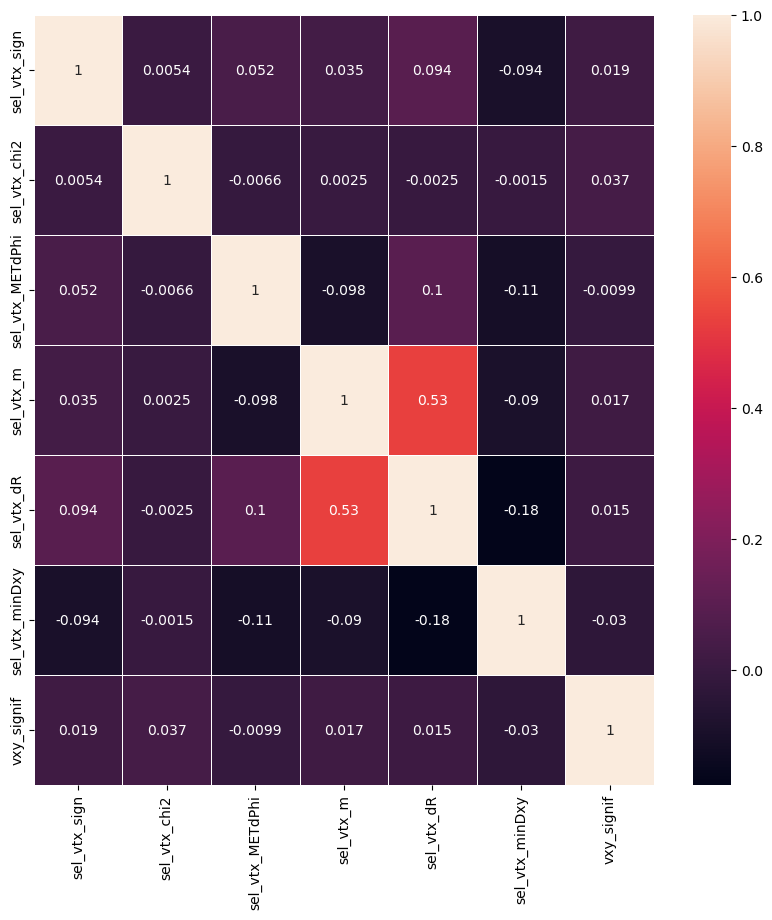

In [56]:
import seaborn as sb
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_all, annot=True, linewidths=.5)

Text(0.5, 1.0, 'PCC in Background Samples (Dataset size: 39037)')

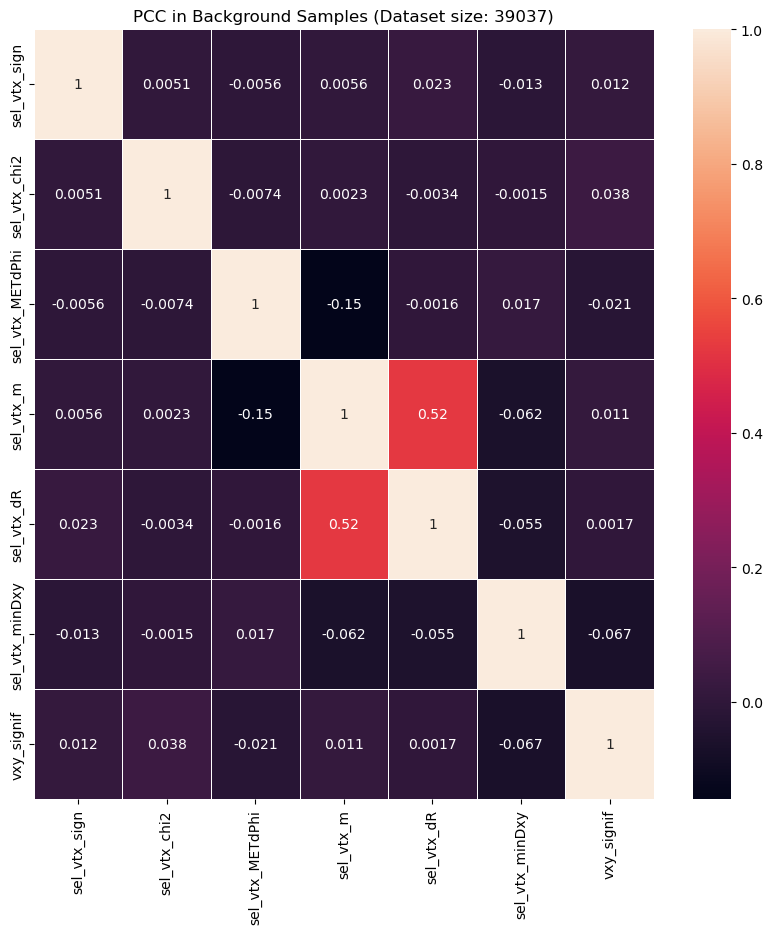

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_bkg, annot=True, linewidths=.5)
plt.title(f'PCC in Background Samples (Dataset size: {bkg_data.shape[0]})') # Unweighted by xsec

Text(0.5, 1.0, 'PCC in Signal Samples (Dataset size: 1921)')

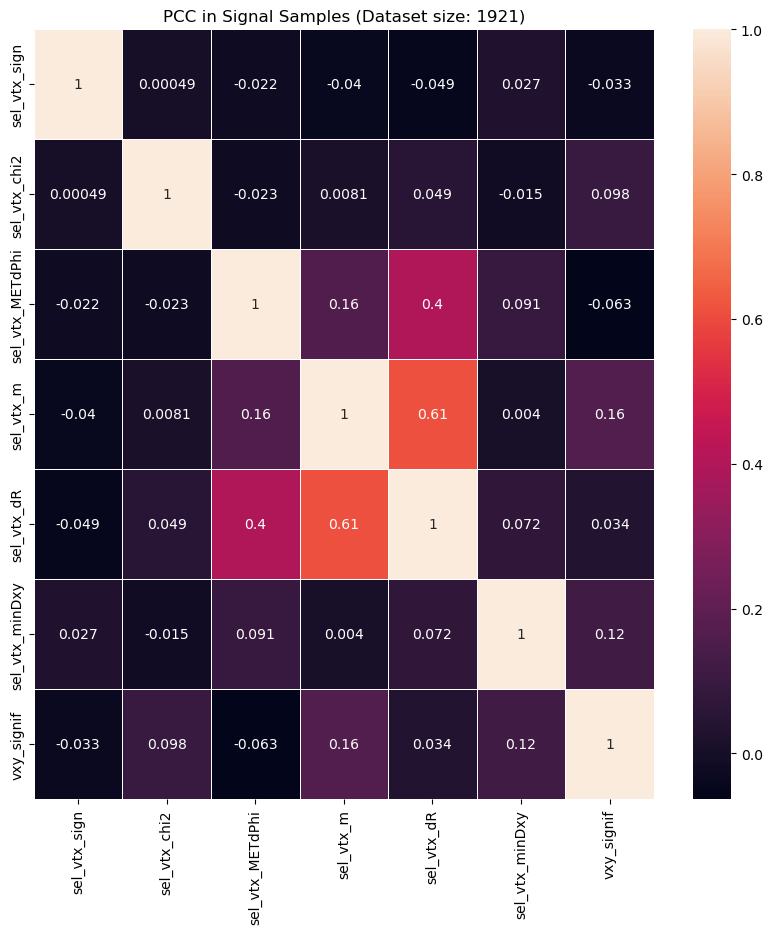

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_sig, annot=True, linewidths=.5)
plt.title(f'PCC in Signal Samples (Dataset size: {sig_data.shape[0]})')